# Inferring Language Models (v3)

```yaml
Course:  DS 5001
Module:  03 Lab
Topic:   Inferring Language Models
Version: 3
Author:  R.C. Alvarado
Date:    22 January 2022 (modified)
```

## Purpose

Wew create word-level langage models from a set of novels and evaluate them.

## Set Up

### Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
from IPython.core.display import HTML
sns.set()

### Configure

In [3]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_dir = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']

In [4]:
OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']
text_file = f'{output_dir}/austen-combo.csv' # Generated in HW 02

In [5]:
ngram_size = 3

# Add-k Smoothing parameter
k = .1

## Get Training Data

Problem: These texts treat Mr. and Mrs. as sentences. Since sentence breaks are represented in the OHCO, to fix this requires reparsing the source text into the TOKEN table with the abbreviation periods removed.

### Import TOKENS

We use our way of representing a text as input. Normally, `term_str` would already be included in the dataframe.

In [6]:
TOKENS = pd.read_csv(text_file).set_index(OHCO).dropna()
TOKENS['term_str'] = TOKENS.token_str.str.lower().str.replace(r'[\W_]+', '', regex=True)
TOKENS = TOKENS[TOKENS.term_str != '']

In [7]:
TOKENS.head()

token_str  term_str
book_id chap_num para_num sent_num token_num                    
1       1        1        0        0               The       the
                                   1            family    family
                                   2                of        of
                                   3          Dashwood  dashwood
                                   4               had       had

Look at book 2 (_Persuasion_) only:

In [8]:
TOKENS.loc[2].head()

token_str  term_str
chap_num para_num sent_num token_num                    
1        0        0        0               Sir       sir
                           1            Walter    walter
                           2            Elliot    elliot
                           3                of        of
                           4          Kellynch  kellynch

### Extract VOCAB from TOKENS

In [9]:
VOCAB = TOKENS.term_str.value_counts().to_frame('n').sort_index()
VOCAB.index.name = 'term_str'
VOCAB['n_chars'] = VOCAB.index.str.len()

In [10]:
VOCAB.head()

,n,n_chars
term_str,,
1,3,1
15,1,2
16,1,2
1760,1,4
1784,1,4


## Handle OOV Terms

We handle out-of-vocabulary (OOV) terms by replacing some of our single-instance (i.e. [_hapax legomena_](https://en.wikipedia.org/wiki/Hapax_legomenon)) words with the `<UNK>` sign.

### Compute HAPAX info

To select a subset from the set of hapax terms, we use the probability features of terms based on length. 

Intuition: This prevents us from getting rid of "good" words that appear in low frequency.

In [11]:
HAPAX = VOCAB[VOCAB.n == 1].n_chars.value_counts().to_frame('n').sort_index() 
HAPAX.index.name = 'n_chars'

In [110]:
HAPAX.style.background_gradient()

,n,p,s,i,h
n_chars,,,,,
1,6,0.001933,517.333333,9.014950,0.017426
2,8,0.002577,388.000000,8.599913,0.022165
3,35,0.011276,88.685714,6.470630,0.072961
4,152,0.048969,20.421053,4.351985,0.213113
5,294,0.094716,10.557823,3.400240,0.322059
6,397,0.127899,7.818640,2.966918,0.379467
7,477,0.153673,6.507338,2.702067,0.415234
8,478,0.153995,6.493724,2.699046,0.415639
9,452,0.145619,6.867257,2.779734,0.404781


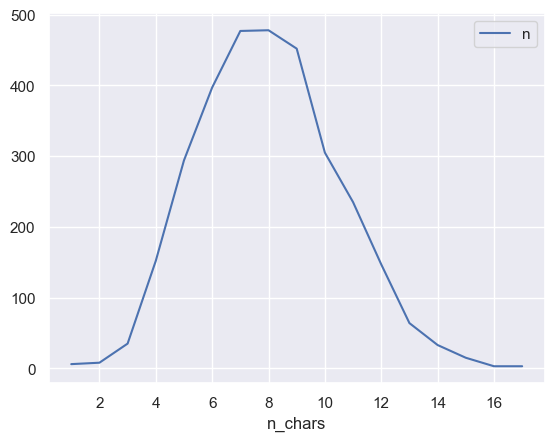

In [13]:
HAPAX.plot();

In [14]:
HAPAX['p'] = HAPAX.n / HAPAX.n.sum()
HAPAX['s'] = 1/HAPAX.p
HAPAX['i'] = np.log2(HAPAX.s)
HAPAX['h'] = HAPAX.p * HAPAX.i
H = HAPAX.h.sum().round(2)
H_max = np.log2(HAPAX.shape[0]).round(2)
R = (1 - H/H_max).round(2) * 100

In [15]:
H, H_max, R

(3.32, 4.09, 19.0)

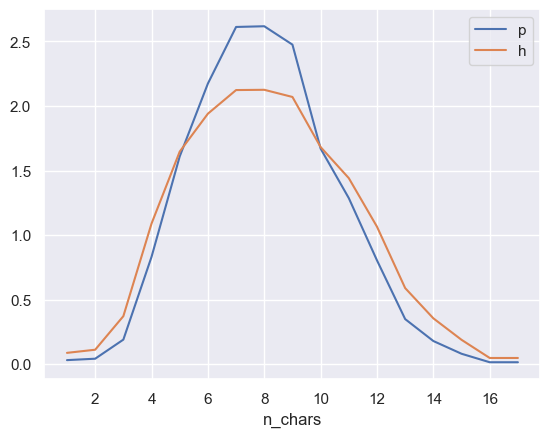

In [17]:
(HAPAX / HAPAX.mean())[['p','h']].plot();

Aside: Note how entropy "regularizes" probability, lowering the higher probabilities and raising the lower ones.

### Method 1: Mean Self-Entropy

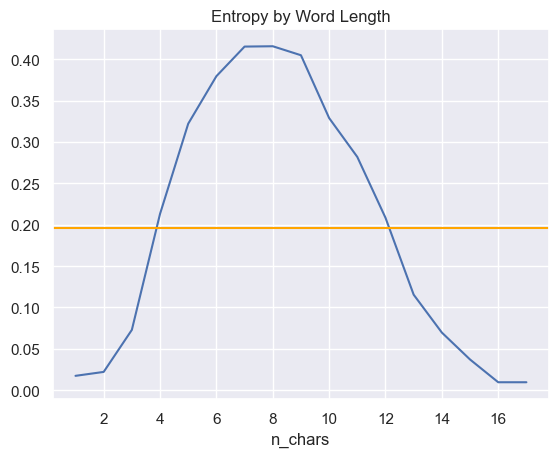

In [18]:
HAPAX.h.plot(title="Entropy by Word Length")
HM = HAPAX.h.mean() # Use mean self-entropy as threshhold
plt.axhline(y=HM, color='orange');

In [19]:
unk_list_h = HAPAX[HAPAX.h < HM].index.to_list()

In [20]:
unk_list_h

[1, 2, 3, 13, 14, 15, 16, 17]

### Method 2: Mean Information

In [21]:
hapax_mean = HAPAX.i.mean() # Use mean as threshhold

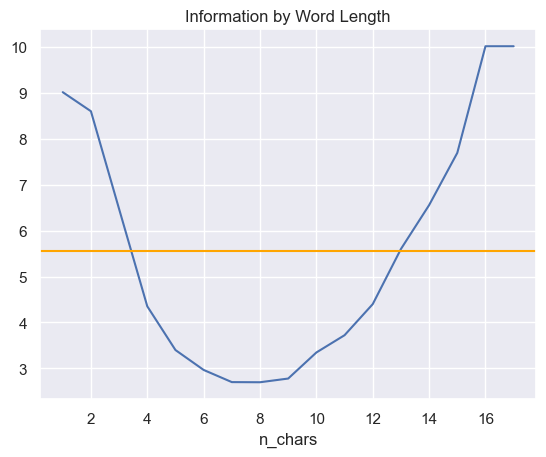

In [22]:
HAPAX.i.plot(title="Information by Word Length")
plt.axhline(y=hapax_mean, color='orange');

Get lengths that are below the average information (or self-entropy).

In [23]:
unk_list_i = HAPAX[HAPAX.i > hapax_mean].index.to_list()

In [24]:
unk_list_i

[1, 2, 3, 13, 14, 15, 16, 17]

Keep the words with lengths with `i` or `h` below the mean.

In [25]:
UNK = VOCAB[VOCAB.n_chars.isin(unk_list_i) & (VOCAB.n == 1)].index.to_list()        

In [26]:
HTML(' '.join(UNK))

### Create Training sentences and vocab

Grab terms (normalized tokens) from TOKENS.

In [27]:
TOKENS['term_str_train'] = TOKENS.term_str

Replace unknowns.

In [28]:
TOKENS.loc[TOKENS.term_str.isin(UNK), 'term_str_train'] = '<UNK>'

Convert tokens to sentences.

In [29]:
S_TRAIN = list(TOKENS.groupby(OHCO[:-1]).term_str_train.apply(lambda x: ' '.join(x)).values)

Inspect results:

In [30]:
S_TRAIN[:5]

['the family of dashwood had long been settled in sussex',
 'their estate was large and their residence was at norland park in the centre of their property where for many generations they had lived in so respectable a manner as to engage the general good opinion of their surrounding acquaintance',
 'the late owner of this estate was a single man who lived to a very advanced age and who for many years of his life had a constant companion and housekeeper in his sister',
 'but her death which happened ten years before his own produced a great alteration in his home',
 'for to supply her loss he invited and received into his house the family of his nephew mr']

Extract the training VOCAB as a list.

In [31]:
# V_TRAIN = TOKENS.term_str_train.drop_duplicates().sort_values().to_list()
V_TRAIN = sorted(list(set(VOCAB.index) - set(UNK))  + ['<UNK>'])

Inspect a slice.

In [32]:
V_TRAIN[100:105]

['accustomary', 'aches', 'aching', 'acknowledge', 'acknowledged']

## Train Models

We now create a dataframe of ngrams, calculating MLE and with smoothing. 

### Parameters

Create names used for ngram element columns (`w0`, `w1`, etc.)

In [33]:
widx = [f'w{i}' for i in range(ngram_size)] 

### Model

We define a class to compute n-gram counts. These counts will be used in our models below.

In [34]:
class NgramCounter():
    
    def __init__(self, sents:[], vocab:[], n:int=3):
        self.sents = sents
        self.vocab = vocab
        self.n = n
        self.widx = [f'w{i}' for i in range(self.n)]
        
    def generate(self):
        
        self.S = pd.DataFrame(dict(sent_str=self.sents))
    
        # Pad sentences 
        pad = '<s> ' *  (self.n - 1)
        
        self.I = (pad + self.S.sent_str + ' </s>')\
            .str.split(expand=True).stack().to_frame('w0')
        self.I.index.names = ['sent_num', 'token_num']
        self.I.loc[~self.I.w0.isin(self.vocab + ['<s>','</s>']), 'w0'] = '<UNK>'

        # Get sentence lengths (these include pads)
        self.S['len'] = self.I.groupby('sent_num').w0.count()
                
        # Add w columns
        for i in range(1, self.n): 
            self.I[f'w{i}'] = self.I[f"w{i-1}"].shift(-1)         
        
        # Generate ngrams
        self.NG = []
        for i in range(self.n):
            self.NG.append(self.I.iloc[:, :i+1].copy())
           
            # Remove spurious rows
#             self.NG[i] = self.NG[i].query(f"w{i} != '<s>'")
                    
        # Generate counts
        self.LM = []
        for i in range(self.n):
            self.LM.append(self.NG[i].value_counts().to_frame('n')) # 2 offset is to remove blank lines

        # Hack to remove single value tuple ...
        self.LM[0].index = [i[0] for i in self.LM[0].index]
        self.LM[0].index.name = 'w0'

In [35]:
train = NgramCounter(S_TRAIN, V_TRAIN)
train.generate()

In [36]:
train.NG[2].loc[0]

,w0,w1,w2
token_num,,,
0,<s>,<s>,the
1,<s>,the,family
2,the,family,of
3,family,of,dashwood
4,of,dashwood,had
5,dashwood,had,long
6,had,long,been
7,long,been,settled
8,been,settled,in


In [37]:
class NgramLanguageModel():
    
    k:float = .5
    
    def __init__(self, ngc:NgramCounter):
        self.S = ngc.S
        self.LM = ngc.LM
        self.NG = ngc.NG
        self.n = ngc.n
        
    def apply_smoothing(self):
        
        self.Z1 = [None for i in range(self.n)] # Unseen N grams, but seen N-1 grams
        self.Z2 = [None for i in range(self.n)] # Unsess N-1 grams too
        V = len(self.LM[0])

        for i in range(self.n):      
            
            # Joint probabilities
            B = V**(i+1)
            self.LM[i]['p'] = (self.LM[i].n + self.k) / (self.LM[i].n.sum() + B * self.k)
            self.LM[i]['log_p'] = np.log2(self.LM[i].p)

            if i > 0:
            
                # Conditional probabilities
                self.LM[i]['cp'] = self.LM[i].p / self.LM[i-1].p
                self.LM[i]['log_cp'] = np.log2(self.LM[i].cp)

                # Handle unseen data
                self.LM[i].sort_index(inplace=True)     
                self.Z1[i] = np.log2(self.k / (self.LM[i-1].n + B*self.k))
                self.Z2[i] = np.log2(self.k / B*self.k)

    def predict(self, test):
        self.T = test
        self.PP = []
        p_key = 'log_cp'
        for i in range(self.n):
            ng = i + 1
            if i == 0:
                self.T.S[f'ng_{ng}_ll'] = self.T.NG[0].join(self.LM[0].log_p, on=widx[:ng])\
                    .groupby('sent_num').log_p.sum()
            else:
                self.T.S[f'ng_{ng}_ll'] = self.T.NG[i].join(self.LM[i][p_key], on=widx[:ng])\
                    .fillna(Z1[i]).fillna(Z2[i])\
                    .groupby('sent_num')[p_key].sum()
                
            self.T.S[f'pp{ng}'] = 2**( -self.T.S[f'ng_{ng}_ll'] / self.T.S['len'])

                

In [39]:
# model = NgramLanguageModel(S_TRAIN, V_TRAIN)
model = NgramLanguageModel(train)
model.k = 1
model.apply_smoothing()

In [40]:
NG = model.NG
LM = model.LM
Z1 = model.Z1
Z2 = model.Z2

In [41]:
LM[2].sort_index()

n             p      log_p        cp  \
w0        w1          w2                                               
1         1760        married   1  3.799825e-12 -37.937204  0.000124   
          1785        </s>      1  3.799825e-12 -37.937204  0.000124   
          ends        </s>      1  3.799825e-12 -37.937204  0.000124   
1760      married     july      1  3.799825e-12 -37.937204  0.000124   
1784      elizabeth   daughter  1  3.799825e-12 -37.937204  0.000124   
...                            ..           ...        ...       ...   
zealous   attention   as        1  3.799825e-12 -37.937204  0.000124   
          officer     too       1  3.799825e-12 -37.937204  0.000124   
          on          the       1  3.799825e-12 -37.937204  0.000124   
zealously active      as        1  3.799825e-12 -37.937204  0.000124   
          discharging all       1  3.799825e-12 -37.937204  0.000124   

                                   log_cp  
w0        w1          w2                   
1         1760        married  -12.973642  
          1785        </s>     -12.973642  
          ends        </s>     -12.973642  
1760      married     july     -12.973642  
1784      elizabeth   daughter -12.973642  
...                                   ...  
zealous   attention   as       -12.973642  
          officer     too      -12.973642  
          on          the      -12.973642  
zealously active      as       -12.973642  
          discharging all      -12.973642  

[160317 rows x 5 columns]

In [42]:
LM[2].loc[('anne', 'was')].sort_values('n', ascending=False)

,n,p,log_p,cp,log_cp
w2,,,,,
not,2,5.699737e-12,-37.352242,0.000008,-16.973642
at,2,5.699737e-12,-37.352242,0.000008,-16.973642
startled,2,5.699737e-12,-37.352242,0.000008,-16.973642
so,1,3.799825e-12,-37.937204,0.000005,-17.558604
now,1,3.799825e-12,-37.937204,0.000005,-17.558604
obliged,1,3.799825e-12,-37.937204,0.000005,-17.558604
one,1,3.799825e-12,-37.937204,0.000005,-17.558604
out,1,3.799825e-12,-37.937204,0.000005,-17.558604
really,1,3.799825e-12,-37.937204,0.000005,-17.558604


In [43]:
PP1 = round(2**(-LM[0].log_p.sum() / len(LM[0])))
PP2 = round(2**(-LM[1].log_cp.sum() / len(LM[1])))
PP3 = round(2**(-LM[2].log_cp.sum() / len(LM[2])))

In [44]:
PP1, PP2, PP3

(47891, 12663, 27600)

## Collect Test Data

### Choose Test Sentences

In [45]:
# Some paragraphs from Austen's _Emma_ and other stuff (first two)
S_TEST = """
The car was brand new
Computer programs are full of bugs
The event had every promise of happiness for her friend 
Mr Weston was a man of unexceptionable character easy fortune suitable age and pleasant manners
and there was some satisfaction in considering with what self-denying generous friendship she had always wished and promoted the match
but it was a black morning's work for her 
The want of Miss Taylor would be felt every hour of every day 
She recalled her past kindness the kindness the affection of sixteen years 
how she had taught and how she had played with her from five years old 
how she had devoted all her powers to attach and amuse her in health 
and how nursed her through the various illnesses of childhood 
A large debt of gratitude was owing here 
but the intercourse of the last seven years 
the equal footing and perfect unreserve which had soon followed Isabella's marriage 
on their being left to each other was yet a dearer tenderer recollection 
She had been a friend and companion such as few possessed intelligent well-informed useful gentle 
knowing all the ways of the family 
interested in all its concerns 
and peculiarly interested in herself in every pleasure every scheme of hers 
one to whom she could speak every thought as it arose 
and who had such an affection for her as could never find fault 
How was she to bear the change 
It was true that her friend was going only half a mile from them 
but Emma was aware that great must be the difference between a Mrs Weston 
only half a mile from them 
and a Miss Taylor in the house 
and with all her advantages natural and domestic 
she was now in great danger of suffering from intellectual solitude 
She dearly loved her father 
but he was no companion for her 
He could not meet her in conversation rational or playful 
The evil of the actual disparity in their ages
and Mr Woodhouse had not married early
was much increased by his constitution and habits 
for having been a valetudinarian all his life 
without activity of mind or body 
he was a much older man in ways than in years 
and though everywhere beloved for the friendliness of his heart and his amiable temper 
his talents could not have recommended him at any time 
Her sister though comparatively but little removed by matrimony 
being settled in London only sixteen miles off was much beyond her daily reach 
and many a long October and November evening must be struggled through at Hartfield 
before Christmas brought the next visit from Isabella and her husband 
and their little children to fill the house and give her pleasant society again 
""".split('\n')[1:-1]

In [46]:
test = NgramCounter(S_TEST, V_TRAIN)
test.generate()
model.predict(test)

In [47]:
round(test.I.w0.value_counts().loc['<UNK>'] / test.I.w0.value_counts().sum(), 2)

0.07

#### Unigrams

In [48]:
test.S.sort_values('pp1')[['sent_str', 'pp1', 'pp2', 'pp3']].style.background_gradient()

,sent_str,pp1,pp2,pp3
25,and a Miss Taylor in the house,87.412144,4751.850773,37755411.179800
29,but he was no companion for her,93.951976,3802.394084,4682878.661787
21,How was she to bear the change,117.397965,17240.626738,173496810.074686
16,knowing all the ways of the family,146.993577,6312.879539,7660979.413575
34,for having been a valetudinarian all his life,147.853328,14121.858948,61839121.223824
5,but it was a black morning's work for her,171.204171,68217.025314,34969326.666392
32,and Mr Woodhouse had not married early,179.521312,43021.404002,951208476.216935
12,but the intercourse of the last seven years,183.222666,9222.324715,14723451.234162
26,and with all her advantages natural and domestic,187.761585,174505.987741,401750944.008146
24,only half a mile from them,189.727209,5480.937450,1592281.296982


In [49]:
test.S.loc[1].sent_str

'Computer programs are full of bugs'

In [50]:
test.S.loc[0].sent_str

'The car was brand new'

#### Bigrams

In [51]:
test.S.sort_values('pp2')[['sent_str', 'pp1', 'pp2', 'pp3']].style.background_gradient()

,sent_str,pp1,pp2,pp3
29,but he was no companion for her,93.951976,3802.394084,4682878.661787
25,and a Miss Taylor in the house,87.412144,4751.850773,37755411.179800
24,only half a mile from them,189.727209,5480.937450,1592281.296982
16,knowing all the ways of the family,146.993577,6312.879539,7660979.413575
12,but the intercourse of the last seven years,183.222666,9222.324715,14723451.234162
33,was much increased by his constitution and habits,292.503590,10012.099238,255649395.017749
28,She dearly loved her father,341.301872,11353.498974,247557601.459594
34,for having been a valetudinarian all his life,147.853328,14121.858948,61839121.223824
20,and who had such an affection for her as could never find fault,222.492168,17123.218058,59925664.492147
21,How was she to bear the change,117.397965,17240.626738,173496810.074686


#### Trigrams

In [52]:
test.S.sort_values('pp3')[['sent_str', 'pp1', 'pp2', 'pp3']].style.background_gradient()

,sent_str,pp1,pp2,pp3
24,only half a mile from them,189.727209,5480.937450,1592281.296982
29,but he was no companion for her,93.951976,3802.394084,4682878.661787
16,knowing all the ways of the family,146.993577,6312.879539,7660979.413575
12,but the intercourse of the last seven years,183.222666,9222.324715,14723451.234162
5,but it was a black morning's work for her,171.204171,68217.025314,34969326.666392
25,and a Miss Taylor in the house,87.412144,4751.850773,37755411.179800
27,she was now in great danger of suffering from intellectual solitude,268.214690,45454.750220,49069793.601134
20,and who had such an affection for her as could never find fault,222.492168,17123.218058,59925664.492147
34,for having been a valetudinarian all his life,147.853328,14121.858948,61839121.223824
22,It was true that her friend was going only half a mile from them,281.947173,20556.547893,111686698.328527


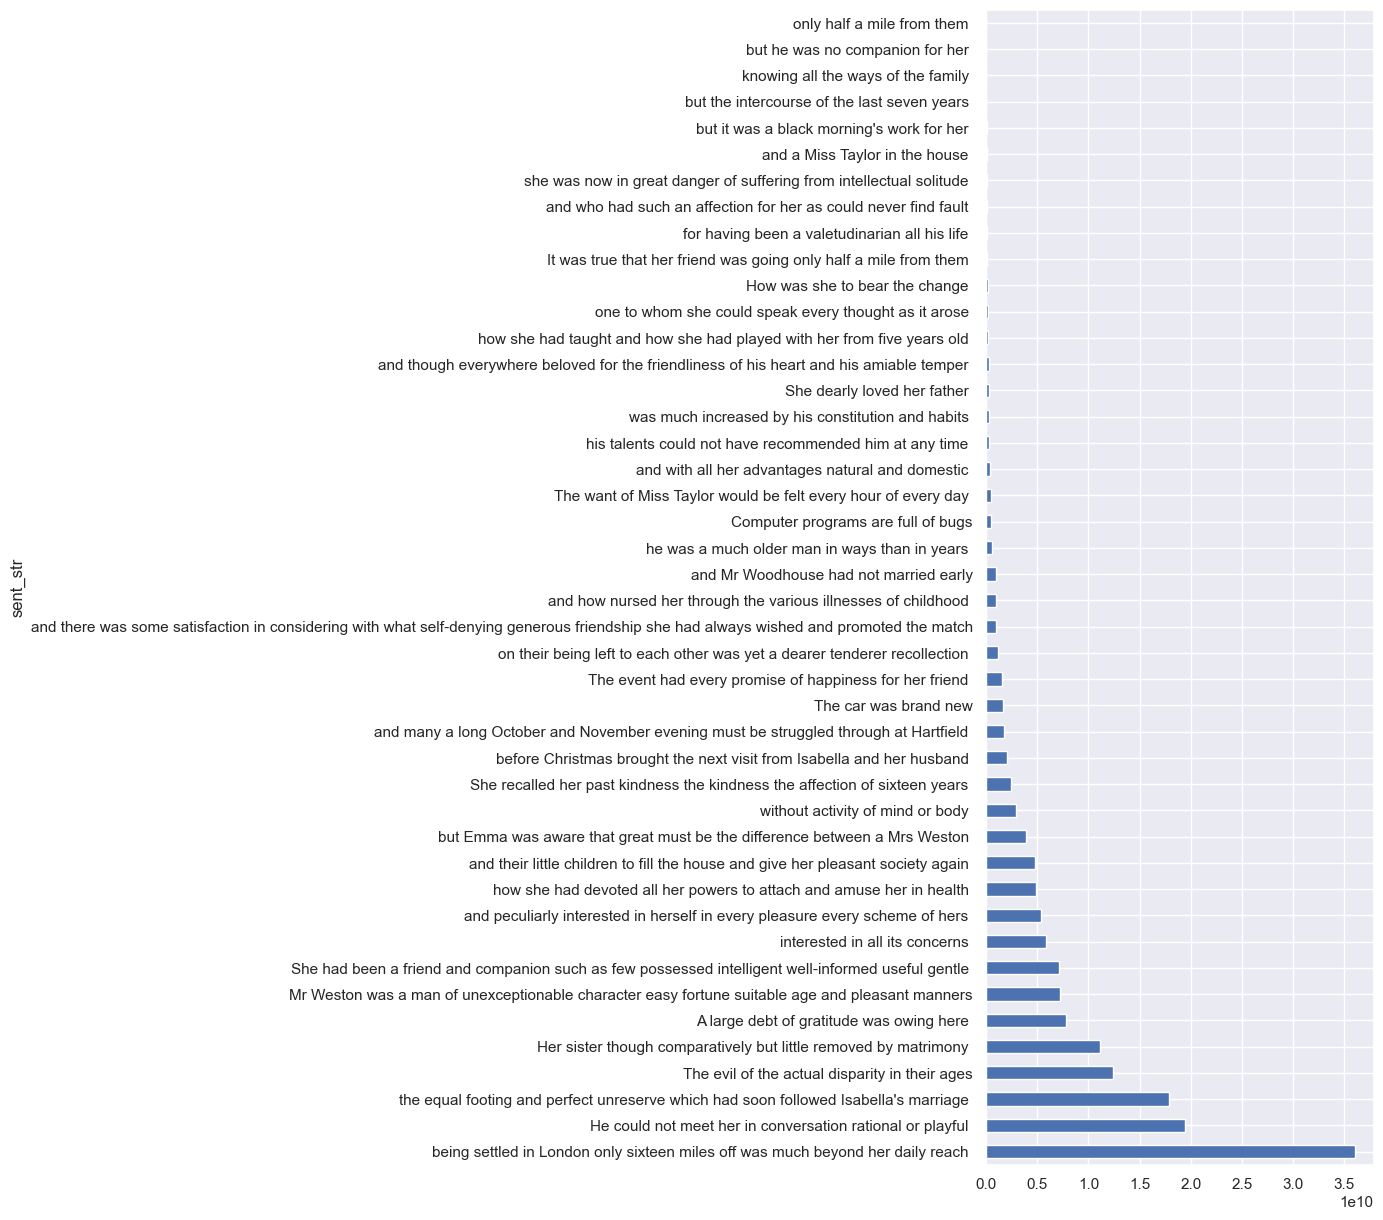

In [53]:
test.S.reset_index().set_index('sent_str').pp3.sort_values(ascending=False).plot.barh(figsize=(5,15));

## Generate Text

In [54]:
LM[2].sort_values('cp')

n             p      log_p            cp     log_cp
w0      w1   w2                                                             
<s>     <s>  rejoicing   1  3.799825e-12 -37.937204  1.824762e-08 -25.707716
             turned      1  3.799825e-12 -37.937204  1.824762e-08 -25.707716
             heaven      1  3.799825e-12 -37.937204  1.824762e-08 -25.707716
             hear        1  3.799825e-12 -37.937204  1.824762e-08 -25.707716
             harry       1  3.799825e-12 -37.937204  1.824762e-08 -25.707716
...                     ..           ...        ...           ...        ...
husband </s> <s>        18  3.609833e-11 -34.689277  1.243211e-04 -12.973642
go      </s> <s>        18  3.609833e-11 -34.689277  1.243211e-04 -12.973642
over    </s> <s>        18  3.609833e-11 -34.689277  1.243211e-04 -12.973642
once    </s> <s>        18  3.609833e-11 -34.689277  1.243211e-04 -12.973642
thing   </s> <s>        30  5.889728e-11 -33.983008  1.243211e-04 -12.973642

[160317 rows x 5 columns]

In [55]:
LM[2].loc[('<s>','<s>')]

,n,p,log_p,cp,log_cp
w2,,,,,
<UNK>,5,1.139947e-11,-36.352242,5.474287e-08,-24.122754
a,153,2.925865e-10,-31.670418,1.405067e-06,-19.440930
about,10,2.089904e-11,-35.477773,1.003619e-07,-23.248285
absence,1,3.799825e-12,-37.937204,1.824762e-08,-25.707716
absolutely,1,3.799825e-12,-37.937204,1.824762e-08,-25.707716
...,...,...,...,...,...
you,254,4.844776e-10,-30.942851,2.326572e-06,-18.713363
young,1,3.799825e-12,-37.937204,1.824762e-08,-25.707716
younger,2,5.699737e-12,-37.352242,2.737143e-08,-25.122754


In [56]:
def generate_text(LM, n=20):
    
    # Start with beginning sentence marker
    words = ['<s>', '<s>']
        
    # Sentence counter
    sent_count = 0
    
    while sent_count < n:
        
        # Get trigram context
        bg = tuple(words[-2:])

        # Get next word
        words.append(LM[2].loc[bg].sample(weights='cp').index.values[0])

        # Terminate when end-of-sentence marker found
        if words[-1] == '</s>':
            sent_count += 1                        
            if sent_count < n:
                words.append('<s>')
    
    # Create text from words
    text = ' '.join(words)
    
    sents = pd.DataFrame(dict(sent_str=text.split('<s> <s>')))
    sents['len'] = sents.sent_str.str.len()
    sents = sents[sents.len > 0]
    sents.sent_str = sents.sent_str.str.replace('<s> ', '')
    sents.sent_str = sents.sent_str.str.replace(' </s>', '')
    sents.sent_str = sents.sent_str.str.strip()
    sents.sent_str = sents.sent_str.str.replace(r" s ", "'s ", regex=True)
    sents['html'] = "<li>" + sents.sent_str.str.upper() + ".</li>"

    output = sents.sort_values('len').html.str.cat(sep='\n')
            
    display(HTML(f"<ol style='font-family:monospace;margin-left:1rem;width:4in;'>{output}</ol>"))
    
    return sents

In [57]:
sents = generate_text(LM, n=20)

## Save

In [58]:
path_prefix = f"{output_dir}/austen-combo"
HAPAX.to_csv(f"{path_prefix}-HAPAX0-v3.csv")
pd.Series(UNK).to_csv(f"{path_prefix}-UNK-v3.txt", 'w')
for n in range(1, ngram_size):
    LM[n].to_csv(f"{path_prefix}-LM{n}-v3.csv")

## Appendix

### Handling Missing Ngrams

* Seen ngram: $ \frac{c + k}{N + Bk} $
* Unseen ngram with seen context: $ \frac{k}{N + Bk} $
* Unseen ngram with unseen context: $ \frac{k}{Bk} \rightarrow \frac{1}{B} $
* Unknown Unigrams: `<UNK>`

### Effective Counts

$ (c_i + \alpha) \frac{M}{M + V\alpha} $

### Perplexity

$ PP(w) = 2^{-\frac{\ell(w)}{M}} $

$ \ell(w) = i(w) $

$ PP(w) = 2^{\frac{i(w)}{M}} $

## Simple Perplexity

Assuming perplexity is just the exponential of the entropy.

In [79]:
def simple_pp(model, feature):
    return np.exp2((model[feature] * np.log2(1/model[feature])).sum())

In [80]:
simple_pp(LM[0], 'p')

404.03773168751627

In [81]:
simple_pp(LM[1], 'p')

1.0785403193056131

In [83]:
simple_pp(LM[2], 'p')

1.0000197022898334

In [85]:
simple_pp(LM[1], 'cp')

2.410370405503277e+113

In [ ]:
simple_pp(LM[2], 'cp')

3.8148551908635914e+43

In [102]:
d = """
0,p,404.0
1,p,1.1
2,p,1.1
1,cp,2.4
2,cp,3.8
""".split("\n")[1:-1]

In [103]:
df = pd.DataFrame([row.split(',') for row in d])

In [104]:
df.columns = ['model','feature','pp']

In [105]:
df = df.set_index(['model','feature'])

In [106]:
df.pp = df.pp.astype('float')

In [108]:
df.unstack()

pp       
feature   cp      p
model              
0        NaN  404.0
1        2.4    1.1
2        3.8    1.1

<Axes: xlabel='model,feature'>

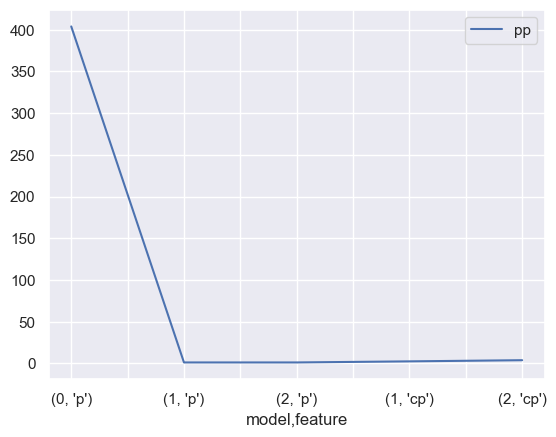

In [101]:
df.plot()